In [2]:
import numpy as np
import pandas as pd
import os
import re

/dsi/sbm/OrrBavly/kidney_data/original_samples/

Load original TSV files, create df containing grouped by aminoAcid seqs with count column

In [28]:
def downsampling(rep, n):
    read_vec = rep['readCount'].values
    read_vec = [int(val) for val in read_vec]
    read_indices = np.zeros(np.sum(read_vec), dtype=int)
    dummy = 0
    for i in range(len(read_vec)):
        read_indices[dummy:dummy + read_vec[i]] = i
        dummy += read_vec[i]
    new_counts = np.random.choice(read_indices, n, replace=False)
    new_reads = np.zeros(len(read_vec), dtype=int)
    for idx in new_counts:
            new_reads[idx] += 1
    downsampled_data = rep.copy()
    downsampled_data['readCount'] = new_reads
    downsampled_data = downsampled_data[downsampled_data["readCount"]!= 0].reset_index(drop = True)
    downsampled_data['readFraction'] = downsampled_data['readCount'] / downsampled_data['readCount'].sum()
    return downsampled_data

In [3]:
def downsample_clonotypes(data, n_sample, prob=True):
    """
    Downsample TCR clonotypes based on their abundance, similar to the immunarch `repSample` function.

    Parameters:
    - data (pd.DataFrame): DataFrame containing clonotypes and their abundance.
      It must have at least the following columns:
        - 'aminoAcid': Unique TCR sequences.
        - 'readCount': Abundance of each clonotype.
    - n_sample (int): Number of clonotypes to sample.
    - prob (bool): If True, sample proportional to abundance ('Count').
                   If False, sample uniformly (ignoring abundance).

    Returns:
    - pd.DataFrame: Downsampled DataFrame containing the sampled clonotypes.
    """
    if 'aminoAcid' not in data.columns or 'readCount' not in data.columns:
        raise ValueError("DataFrame must contain 'aminoAcid' and 'readCount' columns.")

    # Calculate probabilities proportional to clonotype counts if prob=True
    if prob:
        total_count = data['readCount'].sum()
        data['Probability'] = data['readCount'] / total_count
    else:
        data['Probability'] = None  # Uniform sampling

    # Sample n_sample clonotypes based on probabilities. Replace=False ensures Seqs are choosen 0,1 times. 
    sampled_data = data.sample(n=n_sample, weights='Probability' if prob else None, replace=False)
    # Drop the Probability column from the output
    sampled_data = sampled_data.drop(columns=['Probability'], errors='ignore')
    return sampled_data

In [21]:
# Directory containing sample files
samples_dir = "/dsi/sbm/OrrBavly/colon_data/new_mixcr/TRB/"  
sample_files = [f for f in os.listdir(samples_dir) if f.endswith('.tsv')]
sample_dfs = []

In [22]:
aa_column = "aaSeqCDR3"
reads_column = "readCount"

In [23]:
for sample_file in sample_files:
    file_path = os.path.join(samples_dir, sample_file)

    # Read and filter the sample file
    data = pd.read_csv(file_path, sep='\t')
    filtered_data = data.dropna(subset=[aa_column])

    # Group by 'aminoAcid' and aggregate the counts
    grouped_data = (
        filtered_data.groupby(aa_column)[reads_column]
        .sum()
        .reset_index()
    )
    grouped_data.columns = ['aminoAcid', 'readCount']
    # downsample data
    # downsampled_df = downsampling()

    # Append the grouped data with a sample identifier
    grouped_data['Sample'] = sample_file.split('.')[0]
    

    # Append individual sample DataFrame to the list
    sample_dfs.append(grouped_data)

/tmp/ipykernel_3948105/1565466827.py:5: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, sep='\t')
/tmp/ipykernel_3948105/1565466827.py:5: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, sep='\t')
/tmp/ipykernel_3948105/1565466827.py:5: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, sep='\t')
/tmp/ipykernel_3948105/1565466827.py:5: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, sep='\t')
/tmp/ipykernel_3948105/1565466827.py:5: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, sep='\t')
/tmp/ipykernel_3948105/1565466827.py:5: DtypeWarning: Columns (14) have mixed types. 

In [24]:
def summarize_sample_totals(sample_dfs):
    sample_sums = []

    for df in sample_dfs:
        sample_name = df['Sample'].iloc[0]  # Extract sample name from DataFrame
        total_sum_reads = df['readCount'].sum()
        total_sum = df.shape[0]
        sample_sums.append({'Sample': sample_name, 'Total Clonotypes': total_sum, "Total Reads": total_sum_reads})

    # Convert to DataFrame and sort in descending order
    summary_df = pd.DataFrame(sample_sums).sort_values(by='Total Reads', ascending=False)

    # Print nicely formatted summary
    print("\nSample Totals in Descending Order:")
    print(summary_df)

    return summary_df

In [25]:
# Summarize and print sample totals
summarized_totals = summarize_sample_totals(sample_dfs)

# Output individual DataFrames
# for i, df in enumerate(sample_dfs):
#     print(f"\nDataFrame for Sample {i + 1}:")
#     print(df)


Sample Totals in Descending Order:
            Sample  Total Clonotypes  Total Reads
45   P1-S23_output             41447    3840497.0
99   P8-S11_output             87740    3830606.0
22   P5-S21_output             30418    3683812.0
64   P4-S19_output            113188    3626283.0
146   P6-S8_output            109608    3550962.0
..             ...               ...          ...
148   P8-S7_output              2785     334935.0
23   P3-S22_output              4931     292643.0
122  P9-S18_output             13365     253241.0
91   P7-S20_output              7743     209378.0
24   P9-S25_output                15         23.0

[213 rows x 3 columns]


## Run downsample

In [26]:
counts_threshold = 209378
downsampled_folder = "/dsi/sbm/OrrBavly/colon_data/new_mixcr/TRB/downsamples_209378/original_data/"

## Downsampling based on clones

In [29]:

counter = 0
for sample_df in sample_dfs:
    if sample_df['readCount'].sum() >= counts_threshold:
        downsampled_df = downsampling(sample_df, counts_threshold)
        sample_name = sample_df['Sample'].iloc[0]
        # shortened_name = f"{sample_name.split('_')[0]}_{sample_name.split('_')[1]}.csv"
        shortened_name = sample_name.replace("_output", "") + "_TRB_new.csv"
        full_path = os.path.join(downsampled_folder, shortened_name)
        # Drop the 'Sample' column before saving
        downsampled_df = downsampled_df.drop(columns=['Sample'])
        downsampled_df.to_csv(full_path, index=False)
        counter += 1
    else:
        print(f"skipping file: {sample_df['Sample'][0]}")
print(counter)

skipping file: P9-S25_output
212


## Downsampling based on Clonotypes

In [6]:
clonotypes_threshold = 21355
downsampled_folder = "/dsi/sbm/OrrBavly/kidney_data/downsamples_clonotype_21355/"
counter = 0
for sample_df in sample_dfs:
    if sample_df.shape[0] >= clonotypes_threshold:
        downsampled_df = downsample_clonotypes(sample_df, clonotypes_threshold)
        sample_name = sample_df['Sample'].iloc[0]
        shortened_name = f"{sample_name.split('_')[0]}_{sample_name.split('_')[1]}.csv"
        full_path = os.path.join(downsampled_folder, shortened_name)
        # Drop the 'Sample' column before saving
        downsampled_df = downsampled_df.drop(columns=['Sample'])
        downsampled_df.to_csv(full_path, index=False)
        counter += 1
    else:
        print(f"skipping file: {sample_df['Sample'][0]}")
print(counter)

skipping file: STA_073_D0_TCRB
skipping file: AR_009_D0_TCRB
skipping file: AR_024_D0_TCRB
skipping file: AR_037_D0_TCRB
skipping file: STA_002_D0_TCRB
skipping file: STA_065_D0_TCRB
skipping file: STA_072_D0_TCRB
skipping file: STA_049_D0_TCRB
skipping file: STA_020_D0_TCRB
skipping file: STA_007_D0_TCRB
skipping file: AR_019_D0_TCRB
skipping file: AR_058_D0_TCRB
skipping file: STA_071_D0_TCRB
skipping file: STA_048_D0_TCRB
skipping file: AR_069_D0_TCRB
skipping file: AR_086_D0_TCRB
skipping file: AR_031_D0_TCRB
skipping file: AR_032_D0_TCRB
skipping file: AR_036_D0_TCRB
skipping file: STA_025_D0_TCRB
skipping file: AR_061_D0_TCRB
skipping file: AR_041_D0_TCRB
skipping file: AR_046_D0_TCRB
skipping file: STA_023_D0_TCRB
skipping file: AR_049_D0_TCRB
skipping file: AR_030_D0_TCRB
skipping file: AR_034_D0_TCRB
skipping file: STA_066_D0_TCRB
skipping file: AR_028_D0_TCRB
skipping file: AR_033_D0_TCRB
skipping file: AR_064_D0_TCRB
skipping file: AR_059_D0_TCRB
skipping file: AR_040_D0_TCR

## Create single Data csv file

In [ ]:
# Function to create a unified TCR repertoire matrix
def create_tcr_matrix(csv_files, input_dir, output_file):
    all_tcrs = set()
    sample_data = {}

    # Step 1: Collect all unique TCR sequences and fraction counts for each sample
    for csv_file in csv_files:
        file_path = os.path.join(input_dir, csv_file)
        data = pd.read_csv(file_path)

        # Ensure required columns exist
        if {'aminoAcid', 'readFraction'}.issubset(data.columns):
            sample_name = os.path.splitext(csv_file)[0]
            sample_data[sample_name] = {
                row['aminoAcid']: row['readFraction']
                for _, row in data.iterrows()
            }
            all_tcrs.update(data['aminoAcid'].dropna())
        else:
            print(f"Skipping file {csv_file} as required columns are missing.")

    # Step 2: Create a DataFrame where rows are samples and columns are TCR sequences
    all_tcrs = sorted(all_tcrs)  # Sort TCR sequences for consistent column ordering
    tcr_matrix = pd.DataFrame(columns=['Sample'] + all_tcrs)

    for sample_name, tcrs in sample_data.items():
        row = {'Sample': sample_name}
        for tcr in all_tcrs:
            row[tcr] = tcrs.get(tcr, 0)  # Fill with readFraction or 0 if missing
        tcr_matrix = tcr_matrix.append(row, ignore_index=True)

    # Step 3: Save the unified matrix to a CSV file
    tcr_matrix.to_csv(output_file, index=False)
    print(f"Unified TCR matrix saved to {output_file}")

In [ ]:
# Directory containing input CSV files
input_dir = "/dsi/sbm/OrrBavly/kidney_data/downsamples_19789/"  # Update with actual path
csv_files = [f for f in os.listdir(input_dir) if f.endswith('.csv')]

# Output file path
output_file = "unified_tcr_matrix.csv"  # Update with desired output path

# Create the TCR matrix
create_tcr_matrix(csv_files, input_dir, output_file)


# Try

In [7]:
# Directory containing sample files
samples_dir = "/dsi/sbm/or/for_sol/TRB/"  
sample_files = [f for f in os.listdir(samples_dir) if not f.endswith('metadata.txt')]
sample_dfs = []

aa_column = "aaSeqCDR3"
reads_column = "cloneCount"

In [ ]:
for sample_file in sample_files:
    print(sample_file)
    file_path = os.path.join(samples_dir, sample_file)

    # Read and filter the sample file
    data = pd.read_csv(file_path, sep='\t')
    filtered_data = data.dropna(subset=[aa_column])

    # Group by 'aminoAcid' and aggregate the counts
    grouped_data = (
        filtered_data.groupby(aa_column)[reads_column]
        .sum()
        .reset_index()
    )
    grouped_data.columns = ['aminoAcid', 'readCount']
    # downsample data
    # downsampled_df = downsampling()

    # Append the grouped data with a sample identifier
    grouped_data['Sample'] = sample_file.split('.')[0]


    # Append individual sample DataFrame to the list
    sample_dfs.append(grouped_data)

In [9]:
def summarize_sample_totals(sample_dfs):
    sample_sums = []

    for df in sample_dfs:
        sample_name = df['Sample'].iloc[0]  # Extract sample name from DataFrame
        total_sum_reads = df['readCount'].sum()
        total_sum = df.shape[0]
        sample_sums.append({'Sample': sample_name, 'Total Clonotypes': total_sum, "Total Reads": total_sum_reads})

    # Convert to DataFrame and sort in descending order
    summary_df = pd.DataFrame(sample_sums).sort_values(by='Total Reads', ascending=False)

    # Print nicely formatted summary
    print("\nSample Totals in Descending Order:")
    print(summary_df)

    return summary_df

In [10]:
summarized_totals_old = summarize_sample_totals(sample_dfs)


Sample Totals in Descending Order:
                                Sample  Total Clonotypes  Total Reads
111   pool7_S3_TRB_mig_cdr3_clones_all            446447    1032235.0
173  pool9_S10_TRB_mig_cdr3_clones_all            210434     552309.0
82    pool2_S9_TRB_mig_cdr3_clones_all            191430     549486.0
31   pool1_S24_TRB_mig_cdr3_clones_all            191215     540687.0
87   pool1_S21_TRB_mig_cdr3_clones_all             81292     534445.0
..                                 ...               ...          ...
89   pool8_S24_TRB_mig_cdr3_clones_all              5019       6950.0
112   pool8_S7_TRB_mig_cdr3_clones_all              2694       6592.0
20   pool4_S17_TRB_mig_cdr3_clones_all              2200       6439.0
142   pool2_S1_TRB_mig_cdr3_clones_all               493       5735.0
124   pool8_S5_TRB_mig_cdr3_clones_all              1549       3553.0

[216 rows x 3 columns]


In [16]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Paths and columns
new_dir = "/dsi/sbm/OrrBavly/colon_data/new_mixcr/TRB/"
old_dir = "/dsi/sbm/or/for_sol/TRB/"
cdr3_col = "aaSeqCDR3"
new_reads_col = "readCount"
old_reads_col = "cloneCount"


In [18]:
# Match new files: extract full sample ID like P1-S10
new_files = {
    re.match(r'^(P\d+-S\d+)_output\.clones_TRB\.tsv$', f).group(1): f
    for f in os.listdir(new_dir)
    if re.match(r'^(P\d+-S\d+)_output\.clones_TRB\.tsv$', f)
}

# Match old files: extract pool and S number, convert to P-S format
old_files = {}
for f in os.listdir(old_dir):
    match = re.match(r'pool(\d+)_S(\d+)_TRB.*clones.*\.txt$', f)
    if match:
        pool_num, sample_num = match.groups()
        sample_id = f"P{pool_num}-S{sample_num}"
        old_files[sample_id] = f

# Intersect matching samples
matched_samples = set(new_files) & set(old_files)
print(f"Matched {len(matched_samples)} samples.")

# Summary container
summary_rows = []

for sample_id in sorted(matched_samples):
    new_file = os.path.join(new_dir, new_files[sample_id])
    old_file = os.path.join(old_dir, old_files[sample_id])

    try:
        new_df = pd.read_csv(new_file, sep='\t').dropna(subset=[cdr3_col])
        old_df = pd.read_csv(old_file, sep='\t').dropna(subset=[cdr3_col])
    except Exception as e:
        print(f"Error reading files for {sample_id}: {e}")
        continue

    # Group by CDR3 and sum read counts
    new_grouped = new_df.groupby(cdr3_col)[new_reads_col].sum().reset_index()
    old_grouped = old_df.groupby(cdr3_col)[old_reads_col].sum().reset_index()
    new_grouped.columns = [cdr3_col, 'readCount']
    old_grouped.columns = [cdr3_col, 'readCount']

    # Sets for overlap comparison
    cdr3_new = set(new_grouped[cdr3_col])
    cdr3_old = set(old_grouped[cdr3_col])

    shared = cdr3_new & cdr3_old
    only_new = cdr3_new - cdr3_old
    only_old = cdr3_old - cdr3_new

    # Build summary row
    summary_rows.append({
        "Sample": sample_id,
        "New: Total Clonotypes": len(cdr3_new),
        "Old: Total Clonotypes": len(cdr3_old),
        "Shared Clonotypes": len(shared),
        "Unique to New": len(only_new),
        "Unique to Old": len(only_old),
        "New: Total Reads": new_grouped['readCount'].sum(),
        "Old: Total Reads": old_grouped['readCount'].sum(),
        "New: Singletons": (new_grouped['readCount'] == 1).sum(),
        "Old: Singletons": (old_grouped['readCount'] == 1).sum(),
        "New: Doubletons": (new_grouped['readCount'] == 2).sum(),
        "Old: Doubletons": (old_grouped['readCount'] == 2).sum(),
        "% Shared (of New)": round(len(shared) / len(cdr3_new) * 100, 2) if cdr3_new else 0,
        "% Shared (of Old)": round(len(shared) / len(cdr3_old) * 100, 2) if cdr3_old else 0,
    })

# Create final DataFrame
summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values(by="Sample")

# Display nicely
pd.set_option('display.max_columns', None)
print("\nFinal Summary:")
print(summary_df.to_string(index=False))


Matched 212 samples.


/tmp/ipykernel_3948105/1978750535.py:29: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  new_df = pd.read_csv(new_file, sep='\t').dropna(subset=[cdr3_col])
/tmp/ipykernel_3948105/1978750535.py:29: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  new_df = pd.read_csv(new_file, sep='\t').dropna(subset=[cdr3_col])
/tmp/ipykernel_3948105/1978750535.py:29: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  new_df = pd.read_csv(new_file, sep='\t').dropna(subset=[cdr3_col])
/tmp/ipykernel_3948105/1978750535.py:29: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  new_df = pd.read_csv(new_file, sep='\t').dropna(subset=[cdr3_col])
/tmp/ipykernel_3948105/1978750535.py:29: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  new_df = pd.


Final Summary:
Sample  New: Total Clonotypes  Old: Total Clonotypes  Shared Clonotypes  Unique to New  Unique to Old  New: Total Reads  Old: Total Reads  New: Singletons  Old: Singletons  New: Doubletons  Old: Doubletons  % Shared (of New)  % Shared (of Old)
 P1-S1                  11494                  11389              11344            150             45         1708631.0           33296.0                0             4556                1             2576              98.69              99.60
P1-S10                 170362                 137921             135459          34903           2462         1912047.0          256848.0              657            98365             6314            23366              79.51              98.21
P1-S11                  32595                  32597              31631            964            966          793125.0           78560.0                6            18665               19             7665              97.04              97.04
P1-S12  

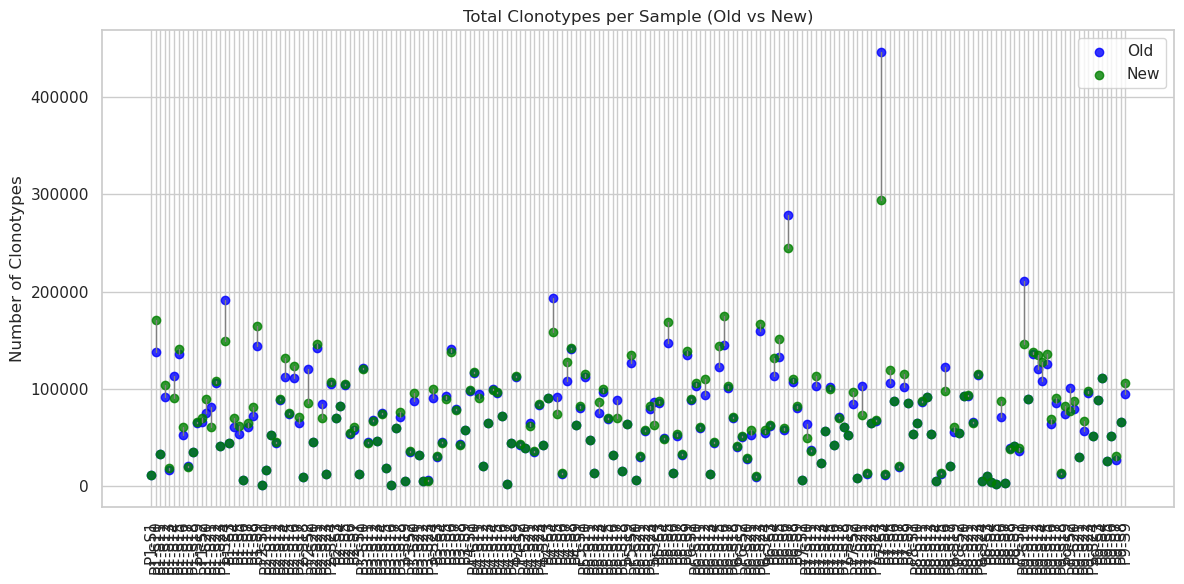

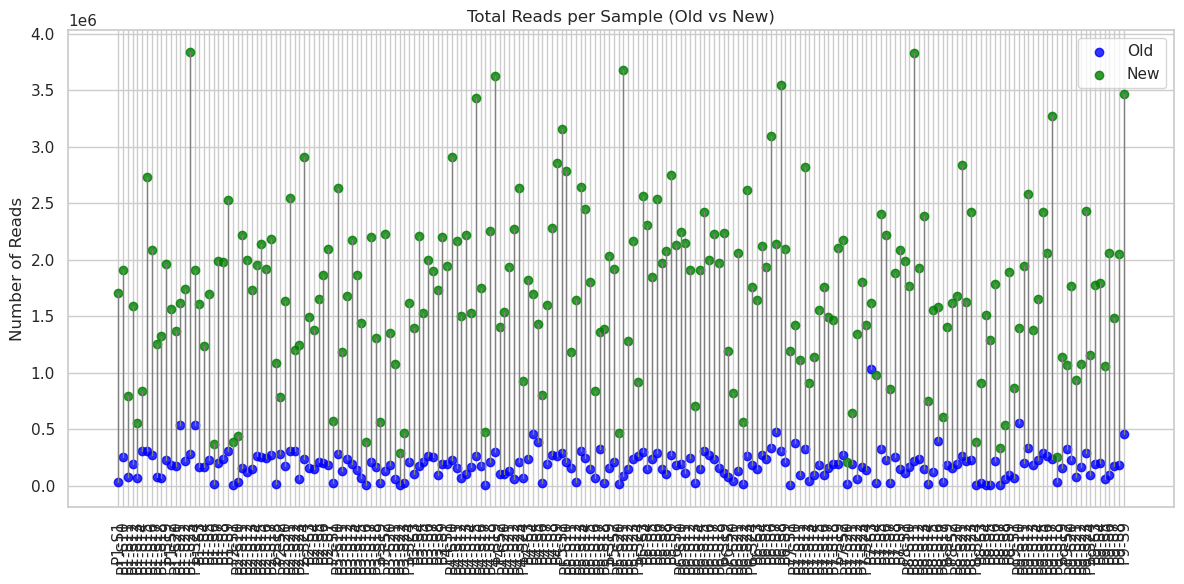

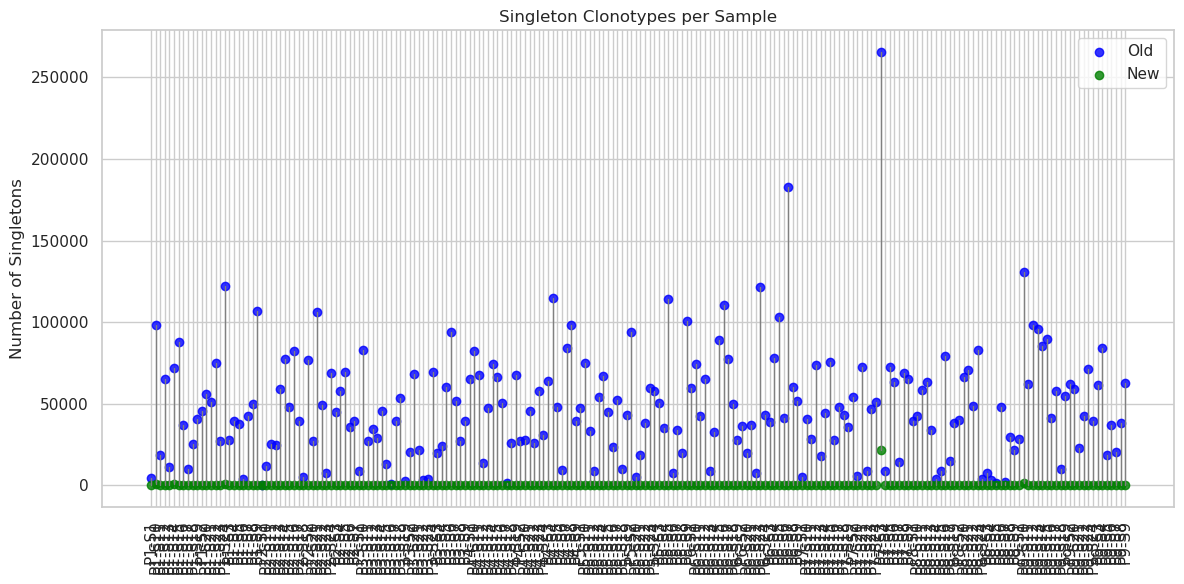

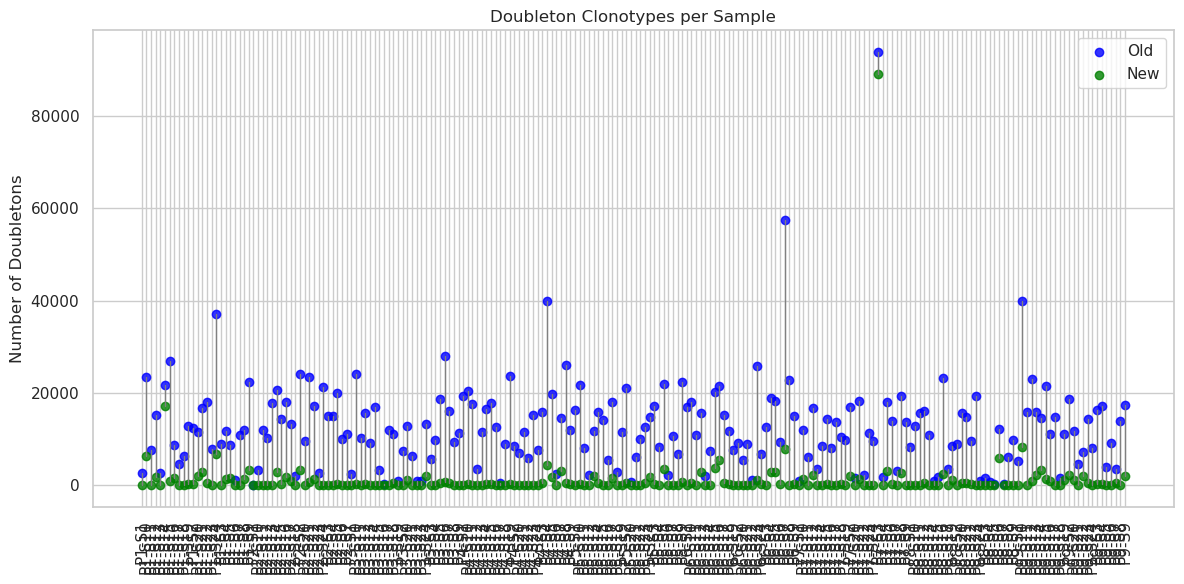

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure data is sorted by Sample
summary_df = summary_df.sort_values("Sample")

# Set plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

def paired_plot(y_old, y_new, label, ylabel):
    plt.figure()
    x = summary_df['Sample']
    y1 = summary_df[y_old]
    y2 = summary_df[y_new]

    # Plot lines between old and new for each sample
    for i in range(len(x)):
        plt.plot([x[i], x[i]], [y1.iloc[i], y2.iloc[i]], color='gray', linewidth=1)

    # Plot points
    plt.scatter(x, y1, color='blue', label='Old', alpha=0.8)
    plt.scatter(x, y2, color='green', label='New', alpha=0.8)

    plt.title(label)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()


# 1. Total clonotypes
paired_plot("Old: Total Clonotypes", "New: Total Clonotypes",
            "Total Clonotypes per Sample (Old vs New)", "Number of Clonotypes")

# 2. Total reads
paired_plot("Old: Total Reads", "New: Total Reads",
            "Total Reads per Sample (Old vs New)", "Number of Reads")

# 3. Singletons
paired_plot("Old: Singletons", "New: Singletons",
            "Singleton Clonotypes per Sample", "Number of Singletons")

# 4. Doubletons
paired_plot("Old: Doubletons", "New: Doubletons",
            "Doubleton Clonotypes per Sample", "Number of Doubletons")


In [ ]:
import os
import re
import pandas as pd

# File locations
old_dir = "/dsi/sbm/or/for_sol/downsampled/TRB/"
new_dir = "/dsi/sbm/OrrBavly/colon_data/new_mixcr/TRB/downsamples_209378/original_data/"

# Regex match and build sample dicts
old_files = {}
for fname in os.listdir(old_dir):
    match = re.search(r'pool(\d+)_S(\d+)', fname)
    if match and "TRB_mig_cdr3_clones_all" in fname:
        pool_num, sample_num = match.groups()
        sample_id = f"P{pool_num}-S{sample_num}"
        old_files[sample_id] = fname

new_files = {
    re.match(r"(P\d+-S\d+)_TRB_new\.csv", fname).group(1): fname
    for fname in os.listdir(new_dir)
    if fname.endswith("_TRB_new.csv")
}

# Get intersected sample IDs
matched_samples = sorted(set(old_files) & set(new_files))
print(f"Found {len(matched_samples)} matched downsampled samples.")

# Compare unique clonotype counts
summary = []

for sample_id in matched_samples:
    try:
        old_path = os.path.join(old_dir, old_files[sample_id])
        new_path = os.path.join(new_dir, new_files[sample_id])

        # Load old (CDR3.aa column)
        old_df = pd.read_csv(old_path, sep='\t')
        old_clonotypes = old_df["CDR3.aa"].dropna().unique()
        old_count = len(old_clonotypes)

        # Load new (aminoAcid column)
        new_df = pd.read_csv(new_path)
        new_clonotypes = new_df["Sequences"].dropna().unique()
        new_count = len(new_clonotypes)

        summary.append({
            "Sample": sample_id,
            "Old: Downsampled Clonotypes": old_count,
            "New: Downsampled Clonotypes": new_count,
        })

    except Exception as e:
        print(f"Error processing {sample_id}: {e}")

# Convert to DataFrame and display
comparison_df = pd.DataFrame(summary).sort_values("Sample")
print(comparison_df.to_string(index=False))


Found 194 matched downsampled samples.
Sample  Old: Downsampled Clonotypes  New: Downsampled Clonotypes
 P1-S1                         9166                        11354
P1-S10                        17525                        94713
P1-S11                        12958                        30739
P1-S12                        15061                        70331
P1-S13                         5991                        16815
P1-S14                        13606                        63896
P1-S15                        15692                        81847
P1-S16                         6415                        33969
P1-S17                         8998                        18848
P1-S18                        13342                        32756
P1-S19                         9961                        44948
 P1-S2                        11409                        50544
P1-S20                        12711                        60860
P1-S21                         5723                

In [33]:
# Set of all sample IDs
old_sample_ids = set(old_files.keys())
new_sample_ids = set(new_files.keys())

# Matched
matched_samples = sorted(old_sample_ids & new_sample_ids)

# Unmatched
only_in_old = sorted(old_sample_ids - new_sample_ids)
only_in_new = sorted(new_sample_ids - old_sample_ids)

# Print results
print(f"\nExpected: 216 matched samples")
print(f"Matched: {len(matched_samples)}")
print(f"Unmatched in OLD (no corresponding new file): {len(only_in_old)}")
for sid in only_in_old:
    print(f"  OLD ONLY: {sid} → {old_files[sid]}")

print(f"\nUnmatched in NEW (no corresponding old file): {len(only_in_new)}")
for sid in only_in_new:
    print(f"  NEW ONLY: {sid} → {new_files[sid]}")


Expected: 216 matched samples
Matched: 194
Unmatched in OLD (no corresponding new file): 4
  OLD ONLY: P2-S19 → pool2_S19_TRB_mig_cdr3_clones_all.txt
  OLD ONLY: P2-S8 → pool2_S8_TRB_mig_cdr3_clones_all.txt
  OLD ONLY: P2-S9 → pool2_S9_TRB_mig_cdr3_clones_all.txt
  OLD ONLY: P8-S18 → pool8_S18_TRB_mig_cdr3_clones_all.txt

Unmatched in NEW (no corresponding old file): 18
  NEW ONLY: P1-S6 → P1-S6_TRB_new.csv
  NEW ONLY: P2-S1 → P2-S1_TRB_new.csv
  NEW ONLY: P2-S18 → P2-S18_TRB_new.csv
  NEW ONLY: P3-S16 → P3-S16_TRB_new.csv
  NEW ONLY: P3-S19 → P3-S19_TRB_new.csv
  NEW ONLY: P3-S22 → P3-S22_TRB_new.csv
  NEW ONLY: P3-S23 → P3-S23_TRB_new.csv
  NEW ONLY: P4-S17 → P4-S17_TRB_new.csv
  NEW ONLY: P5-S20 → P5-S20_TRB_new.csv
  NEW ONLY: P6-S22 → P6-S22_TRB_new.csv
  NEW ONLY: P7-S1 → P7-S1_TRB_new.csv
  NEW ONLY: P7-S20 → P7-S20_TRB_new.csv
  NEW ONLY: P8-S14 → P8-S14_TRB_new.csv
  NEW ONLY: P8-S24 → P8-S24_TRB_new.csv
  NEW ONLY: P8-S3 → P8-S3_TRB_new.csv
  NEW ONLY: P8-S4 → P8-S4_TRB_new.

In [35]:
# Make a copy if needed to avoid modifying the original
comparison_df["Clonotype Difference (New - Old)"] = (
    comparison_df["New: Downsampled Clonotypes"] - comparison_df["Old: Downsampled Clonotypes"]
)

# Print the updated DataFrame with just the relevant columns
print(comparison_df[["Sample", "New: Downsampled Clonotypes", "Old: Downsampled Clonotypes", "Clonotype Difference (New - Old)"]].to_string(index=False))

Sample  New: Downsampled Clonotypes  Old: Downsampled Clonotypes  Clonotype Difference (New - Old)
 P1-S1                        11354                         9166                              2188
P1-S10                        94713                        17525                             77188
P1-S11                        30739                        12958                             17781
P1-S12                        70331                        15061                             55270
P1-S13                        16815                         5991                             10824
P1-S14                        63896                        13606                             50290
P1-S15                        81847                        15692                             66155
P1-S16                        33969                         6415                             27554
P1-S17                        18848                         8998                              9850
P1-S18    

In [36]:
# Directory containing the CSV files
target_dir = "/dsi/sbm/OrrBavly/colon_data/new_mixcr/TRB/downsamples_209378/original_data/"

# Iterate through CSV files
for fname in os.listdir(target_dir):
    if fname.endswith(".csv"):
        file_path = os.path.join(target_dir, fname)
        try:
            df = pd.read_csv(file_path)

            # Rename if column exists
            if "aminoAcid" in df.columns:
                df = df.rename(columns={"aminoAcid": "Sequences"})
                df.to_csv(file_path, index=False)
                print(f"Updated column in: {fname}")
            else:
                print(f"'aminoAcid' not found in: {fname}")
        except Exception as e:
            print(f"Error processing {fname}: {e}")

Updated column in: P6-S9_TRB_new.csv
Updated column in: P7-S4_TRB_new.csv
Updated column in: P6-S11_TRB_new.csv
Updated column in: P3-S20_TRB_new.csv
Updated column in: P9-S12_TRB_new.csv
Updated column in: P3-S16_TRB_new.csv
Updated column in: P6-S6_TRB_new.csv
Updated column in: P1-S8_TRB_new.csv
Updated column in: P2-S6_TRB_new.csv
Updated column in: P9-S5_TRB_new.csv
Updated column in: P1-S2_TRB_new.csv
Updated column in: P6-S14_TRB_new.csv
Updated column in: P2-S3_TRB_new.csv
Updated column in: P7-S11_TRB_new.csv
Updated column in: P3-S15_TRB_new.csv
Updated column in: P4-S5_TRB_new.csv
Updated column in: P8-S2_TRB_new.csv
Updated column in: P4-S8_TRB_new.csv
Updated column in: P1-S23_TRB_new.csv
Updated column in: P4-S24_TRB_new.csv
Updated column in: P4-S23_TRB_new.csv
Updated column in: P5-S21_TRB_new.csv
Updated column in: P4-S2_TRB_new.csv
Updated column in: P9-S17_TRB_new.csv
Updated column in: P6-S4_TRB_new.csv
Updated column in: P8-S7_TRB_new.csv
Updated column in: P1-S15_

In [1]:
import pandas as pd

# Load Excel file
df = pd.read_excel("/home/dsi/orrbavly/GNN_project/data/colon newly diagnosed _Sheba_frozen PBMCS_LIST OF SAMPLES_Sep2023.xlsx")  # Change to actual path if needed

# Rename columns if needed
df = df.rename(columns={"pool #": "Pool", "LN2": "Lane"})

# Normalize lane numbers within each pool
df['Normalized_Lane'] = df.groupby("Pool").cumcount() + 1

# Generate Sample ID as P{pool}-S{normalized_lane}
df['Sample_ID'] = df.apply(lambda row: f"P{row['Pool']}-S{row['Normalized_Lane']}", axis=1)

# Save to CSV
df.to_csv("/home/dsi/orrbavly/GNN_project/data/colon_meta_time.csv", index=False)

print("Saved normalized_samples.csv successfully.")

Saved normalized_samples.csv successfully.


No MiXCR file found containing Sample_ID 'P2-S8'
No MiXCR file found containing Sample_ID 'P2-S9'
No MiXCR file found containing Sample_ID 'P2-S19'
No MiXCR file found containing Sample_ID 'P8-S18'
Rows with issues:
   Sample_ID  extraction_time  num_clonotypes  total_reads
69     P4-S1              NaN           20066    1507558.0

Extraction Time vs. Number of Clonotypes
Pearson r = -0.433 (p = 4.85e-11)
Spearman r = -0.355 (p = 1.2e-07)


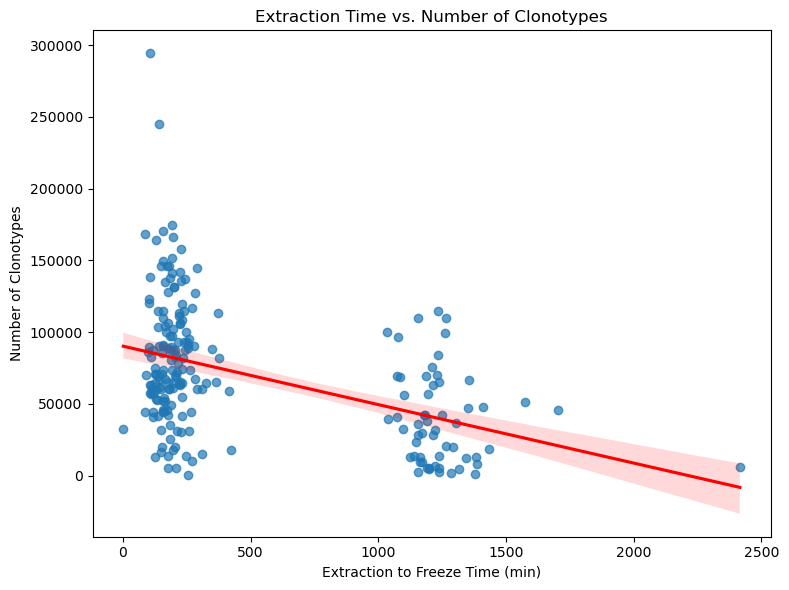


Extraction Time vs. Total Read Count
Pearson r = -0.383 (p = 8.55e-09)
Spearman r = -0.330 (p = 9.66e-07)


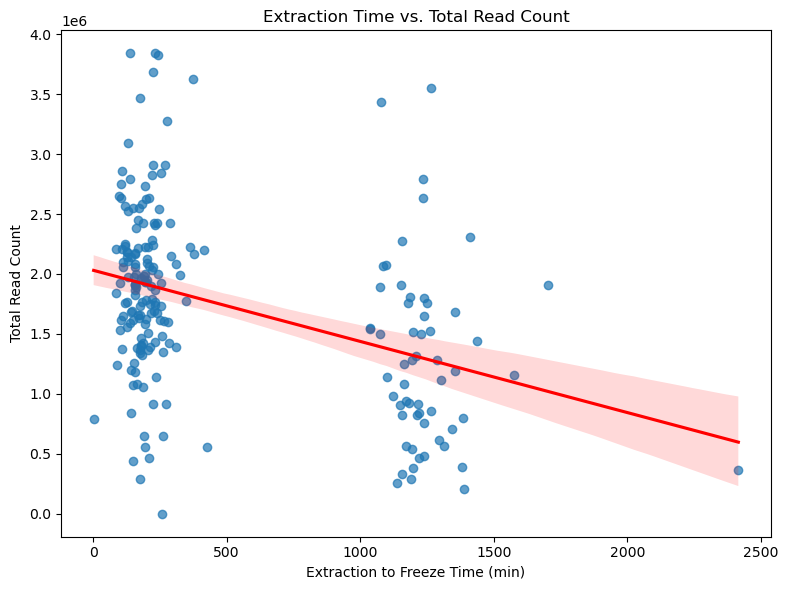

In [6]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
import numpy as np

# Paths
metadata_file = "/home/dsi/orrbavly/GNN_project/data/colon_meta_time.csv"
mixcr_dir = "/dsi/sbm/OrrBavly/colon_data/new_mixcr/TRB/"

# Load metadata
df_meta = pd.read_csv(metadata_file)

# Store results
clonotype_data = []

# Loop through each sample in metadata
for _, row in df_meta.iterrows():
    sample_id = row["Sample_ID"]
    extraction_time = row["extraction_time"]

    # Search for MiXCR file that contains the sample_id in the filename
    matching_files = [f for f in os.listdir(mixcr_dir) if sample_id in f and f.endswith(".tsv")]

    if matching_files:
        mixcr_file = os.path.join(mixcr_dir, matching_files[0])

        try:
            df = pd.read_csv(mixcr_file, delimiter="\t", low_memory=False)
            df = df.dropna(subset=["aaSeqCDR3"])

            num_clonotypes = df["aaSeqCDR3"].nunique()
            total_reads = df["readCount"].sum()

            clonotype_data.append({
                "Sample_ID": sample_id,
                "extraction_time": extraction_time,
                "num_clonotypes": num_clonotypes,
                "total_reads": total_reads
            })

        except Exception as e:
            print(f"Error reading {mixcr_file}: {e}")

    else:
        print(f"No MiXCR file found containing Sample_ID '{sample_id}'")

# Create analysis DataFrame
analysis_df = pd.DataFrame(clonotype_data)

bad_rows = analysis_df[["extraction_time", "num_clonotypes", "total_reads"]].replace([np.inf, -np.inf], np.nan).isna()
print("Rows with issues:")
print(analysis_df[bad_rows.any(axis=1)])

analysis_df = analysis_df.dropna(subset=["extraction_time", "num_clonotypes", "total_reads"])


# --- Correlation ---
def plot_and_correlate(x, y, xlabel, ylabel, title):
    plt.figure(figsize=(8, 6))
    sns.regplot(data=analysis_df, x=x, y=y, scatter_kws={'alpha':0.7}, line_kws={'color':'red'})
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Pearson & Spearman
    pearson_r, pearson_p = pearsonr(analysis_df[x], analysis_df[y])
    spearman_r, spearman_p = spearmanr(analysis_df[x], analysis_df[y])

    print(f"\n{title}")
    print(f"Pearson r = {pearson_r:.3f} (p = {pearson_p:.3g})")
    print(f"Spearman r = {spearman_r:.3f} (p = {spearman_p:.3g})")

    plt.tight_layout()
    plt.show()

# Plot correlations
plot_and_correlate("extraction_time", "num_clonotypes",
                   "Extraction to Freeze Time (min)", "Number of Clonotypes",
                   "Extraction Time vs. Number of Clonotypes")

plot_and_correlate("extraction_time", "total_reads",
                   "Extraction to Freeze Time (min)", "Total Read Count",
                   "Extraction Time vs. Total Read Count")
